In [1]:
#Get the iWidget stuff
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import os
import sys

sys.path.append('/home/michael/jupyter/local-packages')

# Get my Utilities (localUtilities)
from localUtilities import dateUtils  #bPyUtils, configIB 
from localUtilities.webScrape import getCompanEarningsFromYahoo
from localUtilities.ibUtils import getOptionStrategyPrice as strat

import numpy as np
import pandas as pd
import datetime
import random
import itertools
from IPython.display import display, HTML

# matplotlib imports
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

# interactive Shell to see variables outside of print() function - 
#  if this is on one can suppress output by adding a ';' at the end of line 
#   not 100% clear which variables this supresses 
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

# Doc is here: https://ib-insync.readthedocs.io/readme.html
from ib_insync import *
util.startLoop()

ib = IB()
# Connect to IB Gateway / Paper Trade 4002 
#            TWS        / Paper Trade 7495
ib.connect('127.0.0.1', 4002, clientId=4)

<IB connected to 127.0.0.1:4002 clientId=4>

In [2]:
#See if connected 
ib.isConnected()

True

In [3]:
theStock = 'CRM'
anExchange = 'SMART'
theCurrency = 'USD'

contract = Stock(theStock, anExchange, theCurrency ) 
qualityContracts = contract 
ib.qualifyContracts(qualityContracts)
# qualityContracts

# Return a list of expriries and a list of strike prices.
chains = ib.reqSecDefOptParams(qualityContracts.symbol, '', 
                               qualityContracts.secType, qualityContracts.conId)
chain = next(c for c in chains if c.tradingClass == theStock 
             and c.exchange == anExchange)

In [4]:
qualityContracts

Stock(conId=29624264, symbol='CRM', exchange='SMART', primaryExchange='NYSE', currency='USD', localSymbol='CRM', tradingClass='CRM')

In [5]:
#get earnings from Yahoo
yahooEarningsDF = getCompanEarningsFromYahoo.getPastEarnings(theStock)
yahooEarningsDF

,Symbol,Earnings_Date,Company,EPS_Estimate,Reported_EPS,Surprise(%)
0,CRM,2019-06-04 20:00:00,Salesforce.Com Inc,0.61,0.93,+52.46
1,CRM,2019-03-04 21:00:00,Salesforce.Com Inc,0.55,0.7,+27.27
2,CRM,2018-11-27 21:00:00,Salesforce.com Inc,0.5,0.61,+22
3,CRM,2018-08-29 20:00:00,Salesforce.com Inc,0.47,0.71,+51.06
4,CRM,2018-05-29 20:00:00,Salesforce.com Inc,0.46,0.74,+60.87
5,CRM,2018-02-28 21:00:00,Salesforce.com Inc,0.34,0.35,+2.94
6,CRM,2017-11-21 21:00:00,Salesforce.com Inc,0.37,0.39,+5.41
7,CRM,2017-08-22 20:00:00,Salesforce.com Inc,0.32,0.33,+3.13
8,CRM,2017-05-18 20:00:00,Salesforce.com Inc,0.26,0.28,+7.69
9,CRM,2017-02-28 21:00:00,Salesforce.com Inc,0.25,0.28,+12


In [6]:
# # add daysAroundEarnings Days forward - this will be used to count back and plot time
# # durationString,The amount of time (or Valid Duration String units) to go back from the request's given end date and time.

# add X(daysPassEarnings) Days forward past earnings - this will be used to count back from endDateTime
daysPassEarnings = 60

# How far back from daysPassEarnings
durationStrDays = '90 D'
# Bar size
setBarSizeSetting = '1 day'

In [7]:
#create time series panda dataframes from IB
earningsPastStock = []
earningsPastImpVol=[]

# Get Historical Data
for earnData in range(0, len(yahooEarningsDF)):
        earningsPastStock.append(util.df(ib.reqHistoricalData(contract, endDateTime=yahooEarningsDF['Earnings_Date'][earnData]
                                                              +datetime.timedelta(days=daysPassEarnings),  
                                                              durationStr=durationStrDays,barSizeSetting=setBarSizeSetting, 
                                                              whatToShow='TRADES', useRTH=True)))
        earningsPastImpVol.append(util.df(ib.reqHistoricalData(contract, endDateTime=yahooEarningsDF['Earnings_Date'][earnData]
                                                               +datetime.timedelta(days=daysPassEarnings), 
                                                               durationStr=durationStrDays,barSizeSetting=setBarSizeSetting, 
                                                               whatToShow='OPTION_IMPLIED_VOLATILITY', useRTH=True)))

# earningsPastStock
# earningsPastImpVol        

In [8]:
listOfEarningDeltas = []
priceEarnDay=[]

# Get Min/Max Price/Percent in data set 
for count in range(0, len(yahooEarningsDF)): # for all the dates in earningsCalendar
    # recreate index as the 'date' column 
    ePSPrice = earningsPastStock[count].set_index("date", drop=False)
    ePSPrice.index = pd.to_datetime(ePSPrice.index)

    # Get Earning Date and Past/Forward + Plus1 Day
    onEarningDate = yahooEarningsDF['Earnings_Date'][count].date()
    onEarningDatePast = onEarningDate - datetime.timedelta(days=15)
    onEarningDateForward = onEarningDate + datetime.timedelta(days=15)

    
    # Create new dataframe from old // old[['A', 'C', 'D']].copy()
    # Create a new df and set index to date
    onEarningDatePastdf=(ePSPrice.loc[onEarningDatePast:onEarningDateForward,['date','close']].copy()).set_index("date", drop=False)

    anEarningDate=yahooEarningsDF['Earnings_Date'][count].date()   
    
    # Let’s add a new column ‘earningDayPercentDelta’ where entry at each index will be calculated by the values in other columns at that index i.e.
    # dfObj['Percentage'] =  (100-(dfObj['Marks'] / dfObj['Total'] ) * 100

    onEarningDatePastdf['$Deltas'] = round((onEarningDatePastdf['close'] - ePSPrice.close.at[anEarningDate]),2)
    onEarningDatePastdf['%Deltas'] = round(100-((ePSPrice.close.at[anEarningDate]/onEarningDatePastdf['close'])*100),2)

    
    # keep a list of DF of these $ & % updates  ayAfterMove%
#     onEarningDatePastdf['earningDayPriceDelta'] = round((onEarningDatePastdf['close'] - ePSPrice.close.at[anEarningDate]),2)
#     onEarningDatePastdf['earningDayPercentDelta'] = round(100-((ePSPrice.close.at[anEarningDate]/onEarningDatePastdf['close'])*100),2)
    
    listOfEarningDeltas.append(onEarningDatePastdf)   
    
        
    priceEarnDay.append(ePSPrice.close.at[anEarningDate])
 

In [9]:
   yahooEarningsDF

,Symbol,Earnings_Date,Company,EPS_Estimate,Reported_EPS,Surprise(%)
0,CRM,2019-06-04 20:00:00,Salesforce.Com Inc,0.61,0.93,+52.46
1,CRM,2019-03-04 21:00:00,Salesforce.Com Inc,0.55,0.7,+27.27
2,CRM,2018-11-27 21:00:00,Salesforce.com Inc,0.5,0.61,+22
3,CRM,2018-08-29 20:00:00,Salesforce.com Inc,0.47,0.71,+51.06
4,CRM,2018-05-29 20:00:00,Salesforce.com Inc,0.46,0.74,+60.87
5,CRM,2018-02-28 21:00:00,Salesforce.com Inc,0.34,0.35,+2.94
6,CRM,2017-11-21 21:00:00,Salesforce.com Inc,0.37,0.39,+5.41
7,CRM,2017-08-22 20:00:00,Salesforce.com Inc,0.32,0.33,+3.13
8,CRM,2017-05-18 20:00:00,Salesforce.com Inc,0.26,0.28,+7.69
9,CRM,2017-02-28 21:00:00,Salesforce.com Inc,0.25,0.28,+12


In [10]:
    
# onEarningDatePlus1 = dateUtils.getDateStringDashSeprtors(onEarningDatePlus1DateTime)   
maxPriceDelta=[]
maxPercentDelta=[]
minPriceDelta=[]
minPercentDelta=[]
priceDelta1Day=[]
percentDelta1Day=[]


# Count for number of earnings in Yahoo Earnings / yahooEarningsDF
count = 0 
for earnDateDF in listOfEarningDeltas:
    # Get earning date
    anEarningDate=yahooEarningsDF['Earnings_Date'][count].date()

    # Get Earning date +1
    # if Friday / goto Monday
    if anEarningDate.weekday() == 4:
        onEarningDatePlus1 = anEarningDate + datetime.timedelta(days=3)
    else:
        onEarningDatePlus1 = anEarningDate + datetime.timedelta(days=1)

    # Get Max/Min % / $
    maxPriceDelta.append(earnDateDF['$Deltas'].max())
    maxPercentDelta.append(earnDateDF['%Deltas'].max())
    minPriceDelta.append(earnDateDF['$Deltas'].min())
    minPercentDelta.append(earnDateDF['%Deltas'].min())

    # Get earning day + 1 info
    priceDelta1Day.append(earnDateDF.loc[onEarningDatePlus1,'$Deltas'])
    percentDelta1Day.append(earnDateDF.loc[onEarningDatePlus1,'%Deltas'])

    # Count for number of earnings in Yahoo Earnings / yahooEarningsDF
    count = count +1



In [11]:
# add info to yahooEarningsDF dataframe
yahooEarningsDF['EarnDay$']=priceEarnDay
yahooEarningsDF['$Max']=maxPriceDelta
yahooEarningsDF['%Max']=maxPercentDelta
yahooEarningsDF['$Min']=minPriceDelta
yahooEarningsDF['%Min']=minPercentDelta
yahooEarningsDF['dayAfter%']=percentDelta1Day
yahooEarningsDF['dayAfter$']=priceDelta1Day

In [12]:
yahooEarningsDF

,Symbol,Earnings_Date,Company,EPS_Estimate,Reported_EPS,Surprise(%),EarnDay$,$Max,%Max,$Min,%Min,dayAfter%,dayAfter$
0,CRM,2019-06-04 20:00:00,Salesforce.Com Inc,0.61,0.93,+52.46,150.81,10.46,6.49,-5.71,-3.94,4.82,7.63
1,CRM,2019-03-04 21:00:00,Salesforce.Com Inc,0.55,0.7,+27.27,158.50,6.03,3.66,-3.44,-2.22,-0.97,-1.53
2,CRM,2018-11-27 21:00:00,Salesforce.com Inc,0.5,0.61,+22,127.54,16.61,11.52,-6.87,-5.69,9.31,13.10
3,CRM,2018-08-29 20:00:00,Salesforce.com Inc,0.47,0.71,+51.06,154.80,3.38,2.14,-9.78,-6.74,-1.75,-2.66
4,CRM,2018-05-29 20:00:00,Salesforce.com Inc,0.46,0.74,+60.87,126.88,9.62,7.05,-1.44,-1.15,1.87,2.42
5,CRM,2018-02-28 21:00:00,Salesforce.com Inc,0.34,0.35,+2.94,116.25,11.74,9.17,-8.56,-7.95,2.66,3.18
6,CRM,2017-11-21 21:00:00,Salesforce.com Inc,0.37,0.39,+5.41,108.80,0.00,0.00,-8.95,-8.96,-1.84,-1.97
7,CRM,2017-08-22 20:00:00,Salesforce.com Inc,0.32,0.33,+3.13,92.95,3.23,3.36,-5.32,-6.07,0.13,0.12
8,CRM,2017-05-18 20:00:00,Salesforce.com Inc,0.26,0.28,+7.69,87.75,3.52,3.86,-1.23,-1.42,-0.40,-0.35
9,CRM,2017-02-28 21:00:00,Salesforce.com Inc,0.25,0.28,+12,81.35,2.46,2.94,-0.53,-0.66,2.94,2.46


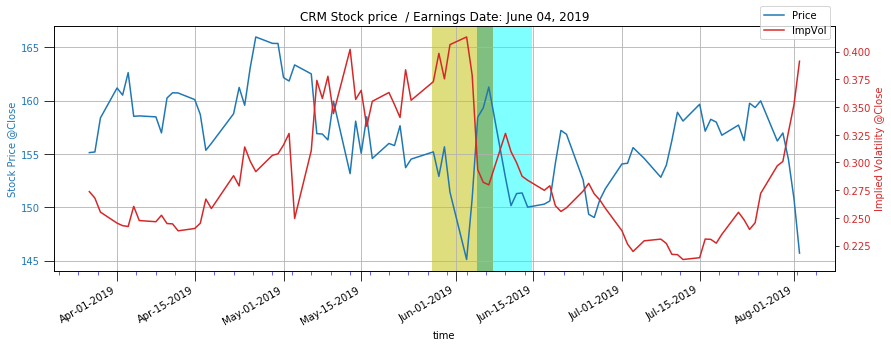

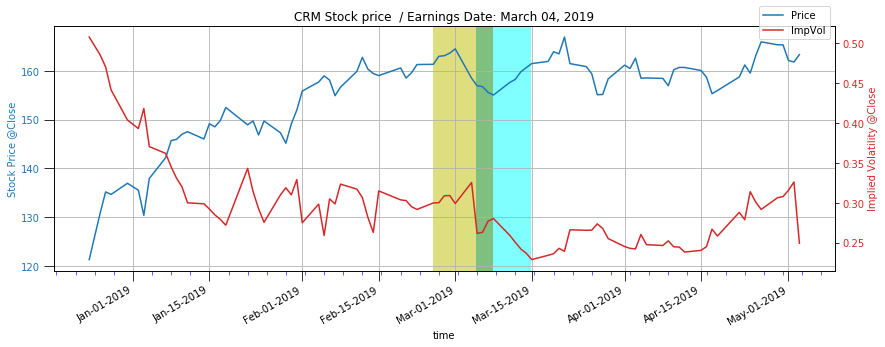

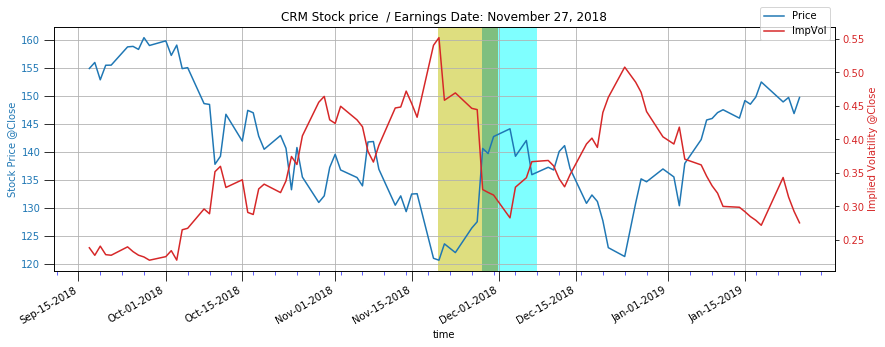

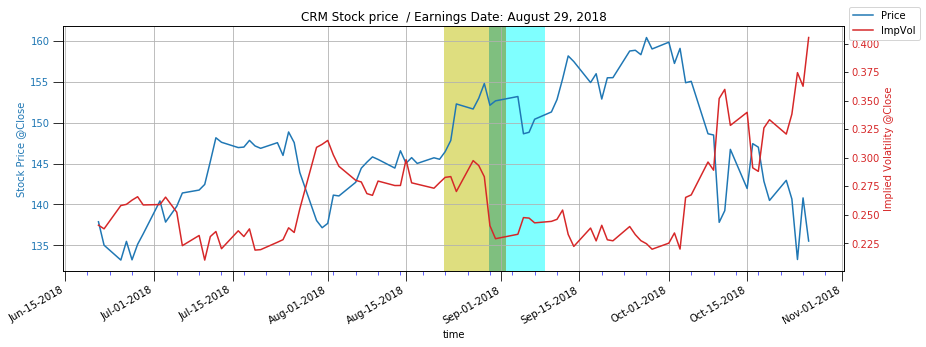

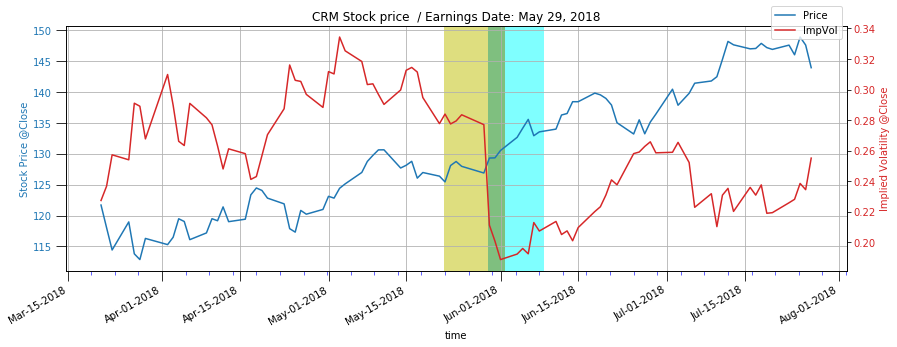

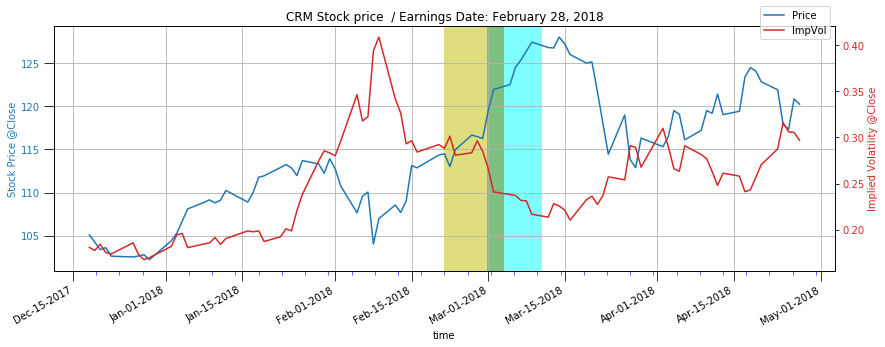

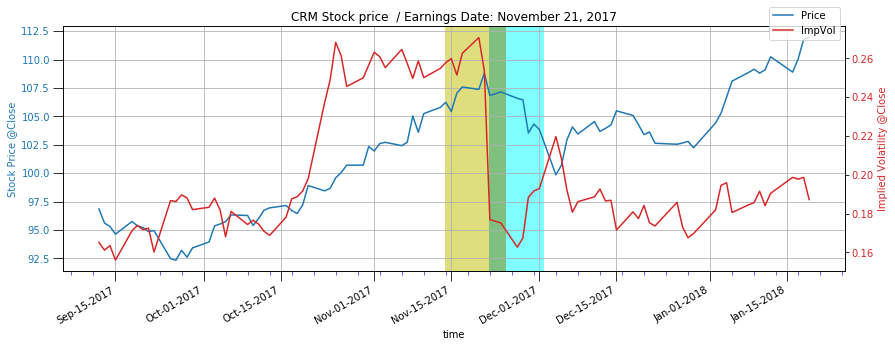

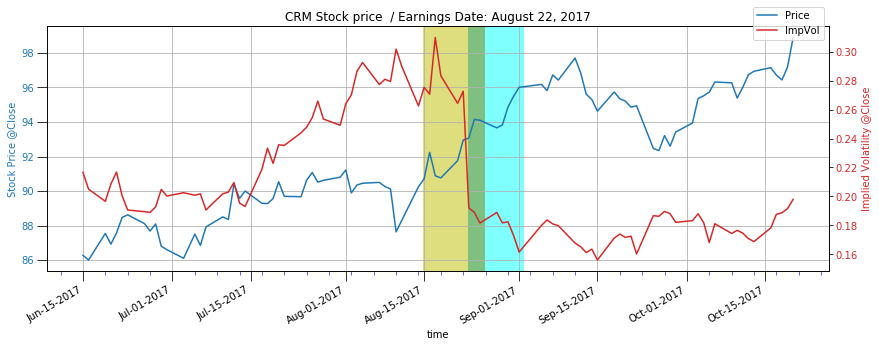

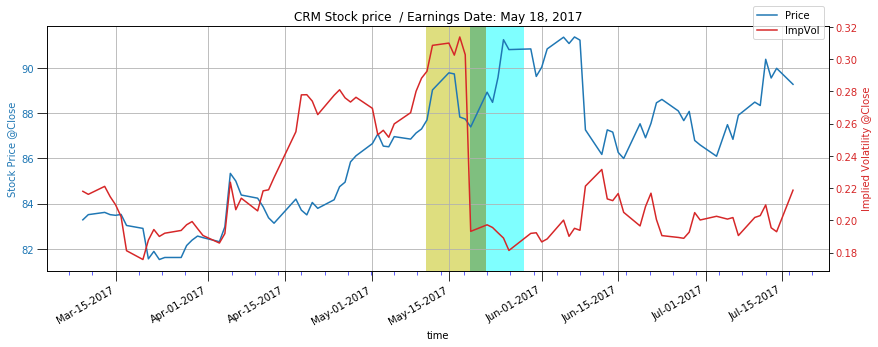

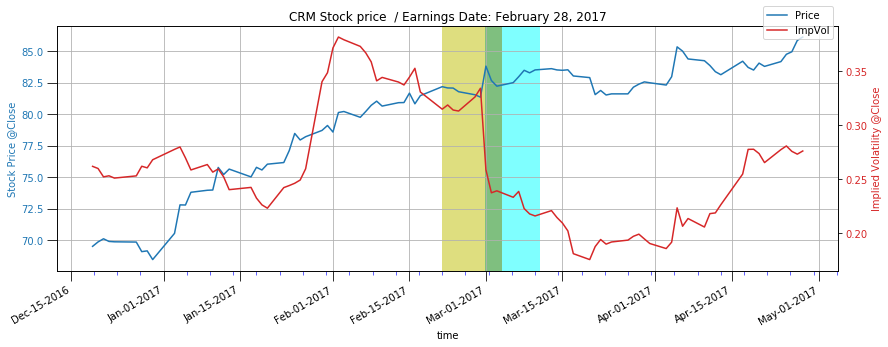

In [13]:
colorStock = 'tab:blue'
colorImpVol = 'tab:red'
xLabel = 'time'
yLabelStock = 'Stock Price @Close';
yLabelImpVol = 'Implied Volatility @Close';
ax1LegendLabel = "Price"
ax2LegendLabel = "ImpVol"

locator = mdates.AutoDateLocator(minticks=5, maxticks=15)
formatter = mdates.ConciseDateFormatter(locator)
myFmt = DateFormatter("%b-%d-%Y")


for earn in range(0, len(yahooEarningsDF)): # for all the dates in earningsCalendar
    fig, ax1 = plt.subplots(figsize=(14,5)); # single Plot

    earningDateString = yahooEarningsDF['Earnings_Date'][earn].strftime("%B %d, %Y")
    theTitle = theStock + " Stock price "+ " / Earnings Date: " + earningDateString
    impVolDataHeaderStockString = '<hr> <strong><span style="color: #ff0000; font-family: arial, helvetica, sans-serif; font-size: large;"> ' + theStock 

    dataHeaderEarningDateString = '<br></span></strong><span style="font-size: small; color: #008000;"><strong><span style="font-family: arial, helvetica, sans-serif;">Earning Date &#9884 ' \
    + earningDateString + '<hr> '
    
    impVolDataHeader = impVolDataHeaderStockString  + ' &#9830; ImpVol ' + dataHeaderEarningDateString
    
    priceHeaderDataHeaderStockString = '<hr> <strong><span style="color: blue; font-family: arial, helvetica, sans-serif; font-size: large;"> ' + theStock 

    priceHeader = priceHeaderDataHeaderStockString  + ' &#9830; Price ' + dataHeaderEarningDateString

    display(HTML(priceHeader))
#     display(onEarningDatePastdf)
    
    ax1.set_title(theTitle);

    ax1.set_xlabel(xLabel);
    ax1.set_ylabel(yLabelStock, color=colorStock);
    ax1.plot(earningsPastStock[earn]['date'], earningsPastStock[earn]['close'], color=colorStock, label=ax1LegendLabel);
    ax1.tick_params(axis='y', labelcolor=colorStock);
    ax1.grid(True);

    # instantiate a second axes that shares the same x-axis
    ax2 = ax1.twinx();
    ax2.set_ylabel(yLabelImpVol, color=colorImpVol)  # we already handled the x-label with ax1
    ax2.plot(earningsPastImpVol[earn]['date'] ,earningsPastImpVol[earn]['close'], color=colorImpVol, label=ax2LegendLabel)
    ax2.tick_params(axis='y', labelcolor=colorImpVol)

    #build Legend for 2 Xaxis
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, bbox_to_anchor=(1.0, 1.1))

    #set up Major/Minor xAxis 
    ax1.xaxis.set_major_locator(locator)
    ax1.xaxis.set_major_formatter(formatter)

    # Format xAxis Date
    ax1.xaxis.set_major_formatter(myFmt)
    ax1.tick_params(which='major', length=10)
    ax1.tick_params(which='minor', length=4, color='b')
    ax1.xaxis.set_minor_locator(AutoMinorLocator())
    
    ax1.axvspan(mdates.date2num(yahooEarningsDF['Earnings_Date'][earn]),
                mdates.date2num(yahooEarningsDF['Earnings_Date'][earn]+datetime.timedelta(days=3)),
                facecolor='g', alpha=0.5)
    ax1.axvspan(mdates.date2num(yahooEarningsDF['Earnings_Date'][earn]),
                mdates.date2num(yahooEarningsDF['Earnings_Date'][earn]-datetime.timedelta(days=8)),
                facecolor='y', alpha=0.5)
    ax1.axvspan(mdates.date2num(yahooEarningsDF['Earnings_Date'][earn]+datetime.timedelta(days=3)),
                mdates.date2num(yahooEarningsDF['Earnings_Date'][earn]+datetime.timedelta(days=10)),
                facecolor='aqua', alpha=0.5)

    fig.autofmt_xdate()
    plt.show()
#     display(listOfEarningDeltas[earn]) #to show Deltas

In [14]:
### yahooEarningsDF   
    
print("Estimated Percent Move for 1 Day: {:5.3f}%".format(strat.getEstimatedPercentMovefor1Day(ib, qualityContracts, chain)))  
print("Estimated Price Move for 1 Day:  ${:2.2f}".format(strat.getEstimatedPriceMovefor1Day(ib, qualityContracts, chain)))      
print("Option Straddle Price:           ${:3.2f}".format(strat.getOptionStraddlePrice(ib, qualityContracts, chain)))
print("Tickers Market Price:            ${:3.2f}".format(strat.getSnapshotTickersMarketPrice(ib, qualityContracts)))


mktData =  ib.reqMktData(contract, "100,101,104,105, 106", False, False, [])
ib.sleep(10)
print('histVolatility     =  {:5.3f}%'.format(mktData.histVolatility*100))
print('impliedVolatility  =  {:5.3f}%'.format(mktData.impliedVolatility*100))
print('avOptionVolume     = ', mktData.avOptionVolume)
print('close              = ${:3.2f}'.format(mktData.last))
print('Expected Price Range Till Next Expiry = +/- ${:3.2f}'.format(strat.getExpectedPriceRangeTillNextExpiryDays(mktData.close, mktData.impliedVolatility)))


Estimated Percent Move for 1 Day:   nan%
Estimated Price Move for 1 Day:  $2.73
Option Straddle Price:           $3.25
Tickers Market Price:            $144.05
histVolatility     =  27.414%
impliedVolatility  =  38.025%
avOptionVolume     =  50190
close              = $144.05
Expected Price Range Till Next Expiry = +/- $0.00


In [28]:
yahooEarningsDF

,Symbol,Earnings_Date,Company,EPS_Estimate,Reported_EPS,Surprise(%),EarnDay$,$Max,%Max,$Min,%Min,dayAfter%,dayAfter$
0,AMAT,2019-05-16 20:00:00,Applied Materials Inc,0.66,0.7,+6.06,41.66,2.30,5.23,-2.97,-7.68,2.44,1.04
1,AMAT,2019-02-14 21:00:00,Applied Materials Inc,0.79,0.81,+2.53,40.71,0.14,0.34,-2.37,-6.18,-4.12,-1.61
2,AMAT,2018-11-16 02:00:00,Applied Materials Inc,0.97,0.97,N/A,35.40,1.88,5.04,-2.78,-8.52,-2.85,-0.98
3,AMAT,2018-11-15 15:00:00,Applied Materials Inc,0.97,0.97,N/A,35.02,2.26,6.06,-2.40,-7.36,1.07,0.38
4,AMAT,2018-08-16 20:00:00,Applied Materials Inc,1.17,1.2,+2.56,47.43,2.75,5.48,-4.70,-11.00,-8.36,-3.66
5,AMAT,2018-05-17 20:00:00,Applied Materials Inc,1.14,1.22,+7.02,53.96,1.57,2.83,-4.45,-8.99,-8.99,-4.45
6,AMAT,2018-02-14 21:00:00,Applied Materials Inc,0.98,1.06,+8.16,51.96,6.85,11.65,-6.21,-13.57,3.76,2.03
7,AMAT,2017-11-16 21:00:00,Applied Materials Inc,0.91,0.93,+2.2,57.84,0.96,1.63,-5.93,-11.42,-2.39,-1.35
8,AMAT,2017-08-17 20:00:00,Applied Materials Inc,0.84,0.86,+2.38,43.12,2.35,5.17,-1.09,-2.59,2.66,1.18
9,AMAT,2017-05-18 20:00:00,Applied Materials Inc,0.76,0.79,+3.95,43.91,2.89,6.18,-2.37,-5.71,0.39,0.17


In [15]:
print('$Max: ', yahooEarningsDF['$Max'].max())
print('%Max: ', yahooEarningsDF['%Max'].max())
print('$Min: ', yahooEarningsDF['$Min'].min())
print('%Min: ', yahooEarningsDF['%Min'].min())
print('dayAfter%Max: ', yahooEarningsDF['dayAfter%'].max())
print('dayAfter$Max: ', yahooEarningsDF['dayAfter$'].max())
print('dayAfter%Min: ', yahooEarningsDF['dayAfter%'].min())
print('dayAfter$Min: ', yahooEarningsDF['dayAfter$'].min())

$Max:  16.61
%Max:  11.52
$Min:  -9.78
%Min:  -8.96
dayAfter%Max:  9.31
dayAfter$Max:  13.1
dayAfter%Min:  -1.84
dayAfter$Min:  -2.66
